In [1]:
import raster_geometry as rg
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
shape = (100, 100, 100)
radius = 5
position = (50, 50, 50)

# target = rg.nd_superellipsoid(shape, radius, position=position, rel_sizes=False, rel_position=False)
print(f"Radius: {radius}, Container shape: {shape}")
%time target = rg.nd_superellipsoid(shape, radius, position=position, rel_sizes=False, rel_position=False)

Radius: 5, Container shape: (100, 100, 100)
CPU times: user 4.84 ms, sys: 5.67 ms, total: 10.5 ms
Wall time: 8.52 ms


In [3]:
shape = (1000, 1000, 1000)
radius = 5
position = (50, 50, 50)

# target = rg.nd_superellipsoid(shape, radius, position=position, rel_sizes=False, rel_position=False)
print(f"Radius: {radius}, Container shape: {shape}")
%time target = rg.nd_superellipsoid(shape, radius, position=position, rel_sizes=False, rel_position=False)

Radius: 5, Container shape: (1000, 1000, 1000)
CPU times: user 1.93 s, sys: 2.05 s, total: 3.98 s
Wall time: 3.99 s


In [4]:
shape = (76, 2404, 3376)
radius = 5
position = (50, 50, 50)

# target = rg.nd_superellipsoid(shape, radius, position=position, rel_sizes=False, rel_position=False)
print(f"Radius: {radius}, Container shape: {shape}")
%time target = rg.nd_superellipsoid(shape, radius, position=position, rel_sizes=False, rel_position=False)

Radius: 5, Container shape: (76, 2404, 3376)
CPU times: user 1.19 s, sys: 1.28 s, total: 2.47 s
Wall time: 2.47 s


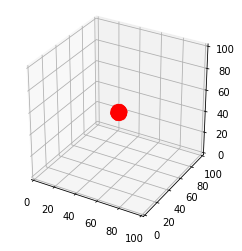

In [9]:
def set_aspect_ratio_equal(ax) -> None:
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    ax.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))

z,x,y = target.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
set_aspect_ratio_equal(ax)
ax.axes.set_xlim3d(left=0, right=shape[1]) 
ax.axes.set_ylim3d(bottom=0, top=shape[2]) 
ax.axes.set_zlim3d(bottom=0, top=shape[0]) 
ax.scatter(x, y, z, zdir='z', c= 'red')
plt.show()